# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Demo" data-toc-modified-id="Demo-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Demo</a></div><div class="lev2 toc-item"><a href="#Load-the-necessary-packages" data-toc-modified-id="Load-the-necessary-packages-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load the necessary packages</a></div><div class="lev2 toc-item"><a href="#Define-the-toy-model-parameters-and-generate-samples" data-toc-modified-id="Define-the-toy-model-parameters-and-generate-samples-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Define the toy model parameters and generate samples</a></div><div class="lev2 toc-item"><a href="#Preprocess-the-data" data-toc-modified-id="Preprocess-the-data-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Preprocess the data</a></div><div class="lev3 toc-item"><a href="#Combine-datasets" data-toc-modified-id="Combine-datasets-131"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Combine datasets</a></div><div class="lev3 toc-item"><a href="#Split-the-initial-sample-into-training-and-validation-sets" data-toc-modified-id="Split-the-initial-sample-into-training-and-validation-sets-132"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Split the initial sample into training and validation sets</a></div><div class="lev3 toc-item"><a href="#Scale-and-center-the-data" data-toc-modified-id="Scale-and-center-the-data-133"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Scale and center the data</a></div><div class="lev2 toc-item"><a href="#Define-the-artificial-neural-nets" data-toc-modified-id="Define-the-artificial-neural-nets-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Define the artificial neural nets</a></div><div class="lev3 toc-item"><a href="#Fully-supervised" data-toc-modified-id="Fully-supervised-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Fully supervised</a></div><div class="lev3 toc-item"><a href="#Weakly-supervised" data-toc-modified-id="Weakly-supervised-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Weakly supervised</a></div><div class="lev2 toc-item"><a href="#Train-the-networks" data-toc-modified-id="Train-the-networks-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Train the networks</a></div><div class="lev3 toc-item"><a href="#Fully-supervised" data-toc-modified-id="Fully-supervised-151"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Fully supervised</a></div><div class="lev3 toc-item"><a href="#Weakly-supervised" data-toc-modified-id="Weakly-supervised-152"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Weakly supervised</a></div><div class="lev2 toc-item"><a href="#Testing-the-results" data-toc-modified-id="Testing-the-results-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Testing the results</a></div><div class="lev3 toc-item"><a href="#Make-the-predictions" data-toc-modified-id="Make-the-predictions-161"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Make the predictions</a></div><div class="lev3 toc-item"><a href="#ROC-curves" data-toc-modified-id="ROC-curves-162"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>ROC curves</a></div><div class="lev3 toc-item"><a href="#AUC" data-toc-modified-id="AUC-163"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>AUC</a></div><div class="lev3 toc-item"><a href="#Plot-the-results" data-toc-modified-id="Plot-the-results-164"><span class="toc-item-num">1.6.4&nbsp;&nbsp;</span>Plot the results</a></div>

# Demo
This notebook walks through the toy model used in the paper, as well as the basics of how to use the weakly supervised loss function. Our work was motivated by [http://arxiv.org/abs/1702.00414] [DNRS](http://arxiv.org/abs/1702.00414). If you use our results, pease cite them as well.

## Load the necessary packages
To run this notebook, you need:
* [Keras](https://keras.io/#installation)
* Keras requires [TensorFlow](https://www.tensorflow.org/versions/r0.12/get_started/os_setup) or [Theano](http://deeplearning.net/software/theano/install.html)
* [scikit-learn](http://scikit-learn.org/stable/)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'cmr10','font.size': 13})
plt.rcParams['axes.unicode_minus']=False

import numpy as np

In [2]:
# Keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [3]:
#sci-kit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# import the weak cost function and the sample generator
import sys
sys.path.append('Functions/')

from SampleGenerators import *
from WeakCostFunction import *

## Define the toy model parameters and generate samples

Our toy model contains two different classes which we want to classify. There are three features which we can use for the classification, and each of the features is bi-modal. The next cell shows the means and standard deviations for each of the three features and modes.

Each line corresponds to one of the features. The two bracketed sets of numbers per line are the two modes. The numbers in (...) are the mean and standard deviation of the mode. The last number in the bracket is the fraction of events for that feature that correspond to that mode.

In [5]:
# note, confusingly use set0 for class 1 and vice versa here...

# class 1, three bimodal features, tuples represent mean & stddev, plus list contains amplt.
set0nums = [[[(26,8),0.5],[(5,4),0.5]],                # x_1 (feature 1)
            [[(0.09,0.04),0.5],[(-0.01,0.03),0.5]],    # x_2 (feature 2)
            [[(0.45,0.04),0.5],[(0.08,0.05),0.5]]      # x_3 (feature 3)
           ]

# class 0, three bimodal features, tuples represent mean & stddev, plus list contains amplt.
set1nums = [[[(18,7),0.5],[(38,9),0.5]],               # x_1 (feature 1)
            [[(-0.06,0.04),0.5],[(0.15,0.03),0.5]],    # x_2 (feature 2)
            [[(0.23,0.05),0.5],[(0.4,0.08),0.5]]       # x_3 (feature 3)
           ]

To get a sense of what these distributions look like, we will plot them below. First define the normal distrubtion as a function.

In [6]:
def Gauss(x,mean,std):
    return 1.0/np.sqrt(2*np.pi* std**2) * np.exp(-0.5*((x-mean)/std)**2)
Gauss_vec = np.vectorize(Gauss)

The distributions for the data are shown below for the three different features.

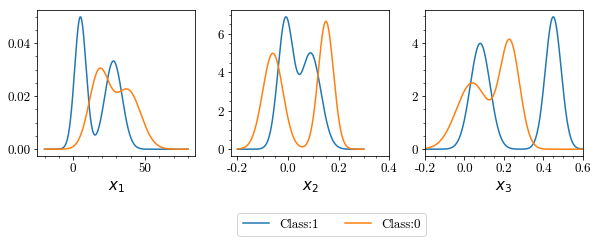

In [7]:
# Note - aren't using the `set0nums` and `set1nums` defined above... ?

plt.figure(figsize=(8.5,3))
plt.subplot(1,3,1)
x=np.linspace(-20,80,1000)
y1= 0.5*Gauss_vec(x,28,6) + 0.5*Gauss_vec(x,5,4)
y0= 0.5*Gauss_vec(x,18,7) + 0.5*Gauss_vec(x,38,9)
plt.plot(x,y1,label='Class:1')#,color='#FEE123')#,alpha=0.25)
plt.plot(x,y0,label='Class:0')#,color='#185844')#,alpha=0.25)
plt.xlabel(r'$x_{1}$',size=15)
plt.minorticks_on()

plt.legend(bbox_to_anchor=(2.5, -.35),ncol=2)

plt.subplot(1,3,2)
x=np.linspace(-.2,0.3,1000)
y1_2= 0.5*Gauss_vec(x,0.09, 0.04) + 0.5*Gauss_vec(x,-0.01, 0.03)
y0_2= 0.5*Gauss_vec(x, -0.06, 0.04) + 0.5*Gauss_vec(x, 0.15, 0.03)
plt.plot(x,y1_2,label='Class:1')#,color='#FEE123')
plt.plot(x,y0_2,label='Class:0')#,color='#185844')
plt.xlabel(r'$x_{2}$',size=15)
plt.xticks([-.2,0,.2,.4])
plt.minorticks_on()

plt.subplot(1,3,3)
x=np.linspace(-.2,0.6,1000)
y1_3= 0.5*Gauss_vec(x, 0.45, 0.04) + 0.5*Gauss_vec(x, 0.08, 0.05)
y0_3= 0.5*Gauss_vec(x, 0.23, 0.05) + 0.5*Gauss_vec(x, 0.04, 0.08)
plt.plot(x,y1_3,label='Class:1')#,color='#FEE123')
plt.plot(x,y0_3,label='Class:0')#,color='#185844')
plt.xlabel(r'$x_{3}$',size=15)
plt.xlim(-.2,.6)
plt.xticks([-.2,0,.2,.4,.6])
plt.minorticks_on()

plt.tight_layout()

Now use the sample generator to make two datasets. The first, "A", will have 40% of the events drawn from the "signal." Dataset "B" will have 70% drawn from the signal.

To use the 'MakeMultiGSamples' function, the first two inputs are the background and signal means and standard deviations for both of the modes. The third input is the fraction of event that are signal, the 4th is what the label of those events are. The last number is the overall size of the sample.

In [8]:
# Note - here, initial signal fraction is always equal to label by definition...

# Sets used for training and validation - note, 3rd arg is real fraction of signal,
# 4th arg is the label, so experiment with that here...

Set_A=MakeMultiGSamples(set0nums, set1nums, 0.4, 0.4, 200000)
XTrainA = Set_A[:,:3]
YTrainPercentageA = Set_A[:,4]
YTrainA = Set_A[:,3]

Set_B= MakeMultiGSamples(set0nums, set1nums, 0.7, 0.7, 200000)
XTrainB = Set_B[:,:3]
YTrainB = Set_B[:,3]
YTrainPercentageB = Set_B[:,4]

80000 120000
Set1 shape: (80000, 4)
Set2 shape: (120000, 4)
140000 60000
Set1 shape: (140000, 4)
Set2 shape: (60000, 4)


In [9]:
# Note, global fraction above is 0.55, so...

# Test set
TestSet = MakeMultiGSamples(set0nums, set1nums, 0.55, 0.55, 200000)
XTest = np.vstack([TestSet[:,:3], TestSet[:,:3]])
YTest = np.append(TestSet[:,3], TestSet[:,3])

110000 90000
Set1 shape: (110000, 4)
Set2 shape: (90000, 4)


## Preprocess the data

### Combine datasets
As shown in the text of the paper, it is key that there are multiple datasets with different fractions. However, for training, the two sets need to be combined together.

In [10]:
# shuffle these?...

X_Train_Initial = np.vstack([XTrainA, XTrainB])
Y_Train_Fractions_Initial = np.append(YTrainPercentageA,YTrainPercentageB).flatten()
Y_Train_Label_Initial = np.append(YTrainA,YTrainB).flatten()

### Split the initial sample into training and validation sets

In [11]:
x_train, x_valid, y_trainBoth, y_validBoth = train_test_split(X_Train_Initial,
                                                              np.vstack([Y_Train_Fractions_Initial,Y_Train_Label_Initial]).T,
                                                              test_size=0.2                                                              
                                                             )

In [12]:
y_train_Fraction = y_trainBoth[:,0]
y_train_Label = y_trainBoth[:,1]

y_valid_Fraction = y_validBoth[:,0]
y_valid_Label = y_validBoth[:,1]

### Scale and center the data

In [13]:
scalerFull = StandardScaler()
x_trainScaled = scalerFull.fit_transform(x_train)
x_validScaled = scalerFull.transform(x_valid)
x_testScaled = scalerFull.transform(XTest)

In [14]:
print x_trainScaled.shape
print x_validScaled.shape
print x_testScaled.shape

(320000, 3)
(80000, 3)
(400000, 3)


In [15]:
print np.mean(x_trainScaled, axis=0)

[ -9.11465400e-15  -3.39571496e-15  -2.12122604e-14]


In [16]:
print np.std(x_trainScaled, axis=0)

[ 1.  1.  1.]


## Define the artificial neural nets
In this section, we will use the Keras framework to define the networks.
### Fully supervised

In [17]:
FullySupervisedModel = Sequential()
FullySupervisedModel.add(Dense(10, activation="sigmoid", kernel_initializer="normal", input_dim=3))
FullySupervisedModel.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))
FullySupervisedModel.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.01))

### Weakly supervised
Notice that we use the user-defined loss function here. This loss function was introduced in DNRS.

In [18]:
more Functions/WeakCostFunction.py

```
def WeakSupervision(y_true, y_pred):
    return K.abs((K.mean(y_pred, axis=-1) - K.mean(y_true, axis=-1)))
```

<img src="./cfo_fig2.png"></img>

So - each event carries a `y_true` that is found by averaging over the batch, using the labels assigned initially (based on the population fractions for the population the event was drawn from).

In [19]:
WeaklySupervisedModel= Sequential()
WeaklySupervisedModel.add(Dense(30, activation="sigmoid", kernel_initializer="normal", input_dim=3))
WeaklySupervisedModel.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))
WeaklySupervisedModel.compile(loss=WeakSupervision,optimizer=Adam(lr=0.0015))

## Train the networks
### Fully supervised
The fully supervised networks are trained using the real labels, which contain either a 0 or a 1 for signal or background.

In [20]:
# For example
np.random.choice(y_train_Label, 10)

array([ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.])

In [21]:
train_fullysupervised = False

In [22]:
# Add checkpoints
if train_fullysupervised:
    checkpointer = ModelCheckpoint('Data/KerasModelWeights/FullySupervisedDemo.h5', 
                                   monitor='val_loss',
                                   save_best_only=True)
    FullySupervisedModel.fit(x=x_trainScaled,
                             y=y_train_Label,
                             validation_data=(x_validScaled, y_valid_Label),
                             epochs = 40,
                             batch_size = 32,
                             verbose = 1,
                             callbacks=[checkpointer]
                            )

# note - the demo originally did not checkpoint and then load the best weights;
# it just used whatever the last training result was...
FullySupervisedModel.load_weights('Data/KerasModelWeights/FullySupervisedDemo.h5')

### Weakly supervised
The weakly supervised network does not know whether an individual event is signal or background. Instead, it only knows if it comes from dataset A or dataset B. The weak loss function, defined in [DNRS](http://arxiv.org/abs/1702.00414), compares the average prediction of the network with the average of the dataset fractions. 

In [23]:
# For example
np.random.choice(y_train_Fraction,10)

array([ 0.4,  0.7,  0.4,  0.4,  0.7,  0.4,  0.7,  0.4,  0.7,  0.4])

In [24]:
train_weaklysupervised = False

In [25]:
# Add checkpoints
checkpointer = ModelCheckpoint('Data/KerasModelWeights/WeaklySupervisedDemo.h5', 
                          monitor='val_loss',
                          save_best_only=True)
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto') 

In [26]:
if train_weaklysupervised:
    WeaklySupervisedModel.fit(x=x_trainScaled,
                              y=y_train_Fraction,
                              validation_data=(x_validScaled, y_valid_Fraction),
                              epochs=100,
                              batch_size=32,
                              verbose = 1,
                              callbacks=[checkpointer, es]
                             )
    
WeaklySupervisedModel.load_weights('Data/KerasModelWeights/WeaklySupervisedDemo.h5')

## Testing the results
Now that the models have been trained, lets see how well they do at classifying the test set. We will do this using the scikit-learn functions to get the ROC curve and the area under the curve.

### Make the predictions

In [27]:
FullySupervisedPredictions = FullySupervisedModel.predict(x_testScaled)

In [28]:
WeaklySupervisedPredictions = WeaklySupervisedModel.predict(x_testScaled)

### ROC curves

In [29]:
FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(YTest,FullySupervisedPredictions)

In [30]:
FalsePositiveWeak, TruePositiveWeak, ThresholdWeak = metrics.roc_curve(YTest,WeaklySupervisedPredictions)

### AUC

In [31]:
AUCFull = metrics.auc(FalsePositiveFull,TruePositiveFull)
AUCWeak = metrics.auc(FalsePositiveWeak,TruePositiveWeak)
print "The area under the curves are:"
print "Full:{0:.2f}, Weak:{1:.2f}".format(AUCFull, AUCWeak)

The area under the curves are:
Full:0.97, Weak:0.96


### Plot the results

/Users/gnperdue/miniconda2/envs/py2tf/lib/python2.7/site-packages/matplotlib/mathtext.py:866: MathTextWarning: Font 'default' does not have a glyph for '-' [U+2212]
  MathTextWarning)
/Users/gnperdue/miniconda2/envs/py2tf/lib/python2.7/site-packages/matplotlib/mathtext.py:867: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


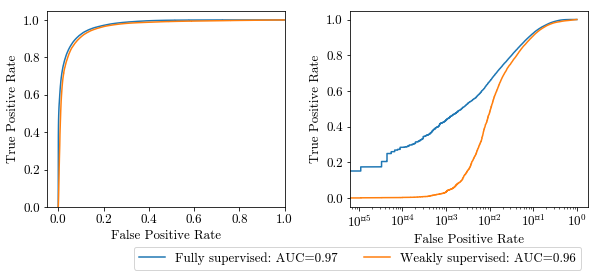

In [32]:
plt.figure(figsize=(8.5,3.7))
plt.subplot(1,2,1)

plt.plot(FalsePositiveFull,TruePositiveFull)
plt.plot(FalsePositiveWeak,TruePositiveWeak)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(-.05,1)
plt.ylim(0,1.05)

plt.subplot(1,2,2)

plt.plot(FalsePositiveFull,TruePositiveFull, label='Fully supervised: AUC={0:.2f}'.format(AUCFull))
plt.plot(FalsePositiveWeak,TruePositiveWeak, label='Weakly supervised: AUC={0:.2f}'.format(AUCWeak))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1, -0.17),ncol=2)
plt.tight_layout()

These plots have the same information, but the one on the left has linear scales, while the one on the right has a log scale for the x-axis. Even though it looks like the AUCs are very similar for the two, at high purity samples (very low false positive rates) the true positve rate have be very different.